In [1]:
import json_lines
from langdetect import detect
from langdetect import detect_langs
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.neural_network import MLPClassifier
import numpy as np

from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

lemmatizer = WordNetLemmatizer()
REMOVEABLE_CHARS = "»<>123456789\/&()?:!.,;'´+*"
ALL_TAGS = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
ACCEPTABLE_TAGS = ALL_TAGS
# ACCEPTABLE_TAGS = ['CC', 'DT', 'EX', 'FW', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'PDT',
#  'POS', 'PRP', 'PRP$', 'RP', 'TO', 'UH', 'VBD', 'VBG', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
MAX_FEATURES = 200
MIN_ENGLISH = 0.9999
LIMIT_INPUT_ROWS = 1000 # to stop run times hindering development (making this < 500 usually makes the graph angry)

def get_wordnet_pos(tag): # Return a char, based on input tag, that is used as a param in lemmatisation for enhanced results
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [2]:
# READ IN INFO
reviews= []; polarity= []; are_early= [];
with open ('reviews.json', 'rb') as f:
    i= 0
    for item in json_lines.reader(f):
        if i < LIMIT_INPUT_ROWS:
            try:
                langs = detect_langs(item['text'])
            except:
                pass
            for lang in langs:
                if str(lang)[0:2] == 'en':
                    if float(str(lang)[3:]) > MIN_ENGLISH:
                        reviews.append(item['text'])
                        polarity.append(item['voted_up'])
                        are_early.append(item['early_access'])
                        i+= 1
                        break
        else:
            break

In [3]:
# FILTER TEXT
for i, text in enumerate(reviews):
    text_words = nltk.word_tokenize(text.lower())
    tags = nltk.pos_tag(text_words)
    #print(tags)
    new_text= [];
    for j, word in enumerate(text_words):
        for char in word:
            if char in REMOVEABLE_CHARS:
                break
        else:
            wordnet_pos = get_wordnet_pos(tags[j][1])
            if wordnet_pos != '':
                new_text.append(lemmatizer.lemmatize(word, wordnet_pos))
            continue
    reviews[i] = new_text

for i, text in enumerate(reviews): 
    new_text= []
    tags = nltk.pos_tag(reviews[i])
    for j, word in enumerate(text):
        if tags[j][1] in ACCEPTABLE_TAGS:
            new_text.append(word)
    reviews[i] = new_text
    #print(tags)

In [4]:
# MOST FREQ WORDS AS FEATURES
word_counts = {}
for text in reviews:
    for word in text:
        if word in word_counts:
            word_counts[word]+= 1
        else:
            word_counts[word]= 1
word_counts= {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}
trimd_word_counts= {}
if len(word_counts) > MAX_FEATURES:
    for i, entry in enumerate(word_counts):
        if i >= MAX_FEATURES:
            break
        trimd_word_counts[entry]= word_counts[entry]
    word_counts= trimd_word_counts
tags = nltk.pos_tag(word_counts.keys()); # this part is just for the below print statement
for i, word in enumerate(word_counts):
    print("word: ", word, "| tag: ", tags[i][1], "| count: ",word_counts[word],"\n")

word:  be | tag:  VB | count:  2329 

word:  game | tag:  NN | count:  1595 

word:  i | tag:  NN | count:  1334 

word:  have | tag:  VBP | count:  608 

word:  do | tag:  VBN | count:  449 

word:  play | tag:  VB | count:  398 

word:  get | tag:  VB | count:  355 

word:  not | tag:  RB | count:  312 

word:  good | tag:  JJ | count:  272 

word:  so | tag:  RB | count:  229 

word:  make | tag:  VB | count:  226 

word:  just | tag:  RB | count:  225 

word:  more | tag:  RBR | count:  212 

word:  fun | tag:  JJ | count:  201 

word:  time | tag:  NN | count:  190 

word:  very | tag:  RB | count:  179 

word:  great | tag:  JJ | count:  170 

word:  really | tag:  RB | count:  168 

word:  story | tag:  NN | count:  161 

word:  well | tag:  RB | count:  150 

word:  go | tag:  VB | count:  147 

word:  best | tag:  JJS | count:  144 

word:  also | tag:  RB | count:  136 

word:  player | tag:  NN | count:  136 

word:  even | tag:  RB | count:  133 

word:  love | tag:  VB | c

In [5]:
# CREATE 1-HOT ENCODINGS
amount_features = len(word_counts)
one_hots = []
for text in reviews:
    one_hot = []
    for i in range(MAX_FEATURES):
        one_hot.append(0)
    for word in text:
        if word in word_counts:
            one_hot[list(word_counts).index(word)]+= 1
    one_hots.append(one_hot)

for i, one_hot in enumerate(one_hots): # convert array of lists into 2d array
    one_hot_arr = np.array(one_hot)
    one_hots[i] = one_hot_arr
one_hots = np.array(one_hots)

overall accuracy:  0.84
Trues: 174
Falses: 26


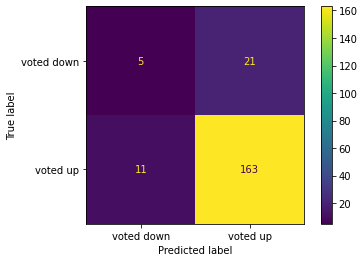

In [6]:
# print("len one_hots: "+str(len(one_hots)))
# print("polarity: "+str(len(polarity)))
# print("reviews: "+str(len(reviews)))
# for i, text in enumerate(reviews):
#     print("polarity: "+str(polarity[i]))
#     print("reviews: "+str(reviews[i]))

# TRAIN, PREDICT, GRAPH
X_train, X_test, y_train, y_test = train_test_split(one_hots, polarity, random_state=1, test_size=0.2) # change the second param here to switch between polarity and early_access
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_test_scaled = sc_X.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes=(amount_features, int(amount_features/2), int(amount_features/4)), activation="relu", solver="adam", random_state=1).fit(X_train_scaled, y_train)
y_pred=clf.predict(X_test_scaled)
print("overall accuracy: ",clf.score(X_test_scaled, y_test))
try:
    fig=plot_confusion_matrix(clf, X_test_scaled, y_test, display_labels=["voted down", "voted up"])
except ValueError:
    pass

# fig.figure_.suptitle("Confusion Matrix")
# plt.show()

Falses= 0
Trues= 0
for y in y_test:
    if y == False:
        Falses+= 1
    if y == True:
        Trues+= 1
print("Trues: "+str(Trues))
print("Falses: "+str(Falses))